## Imports

In [ ]:
import numpy as np
!pip install drjit mitsuba sionna-rt
import torch
import drjit as dr
import time
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
from PIL import Image
import json
import os

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import LambertianPattern, DirectivePattern, BackscatteringPattern,\
                      load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, cpx_abs, cpx_convert

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization


from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, watt_to_dbm,\
                      RadioMapSolver, PathSolver

In [ ]:
nb_samples = 10**8

# Exemple

(2, 600, 600)
(600, 600)


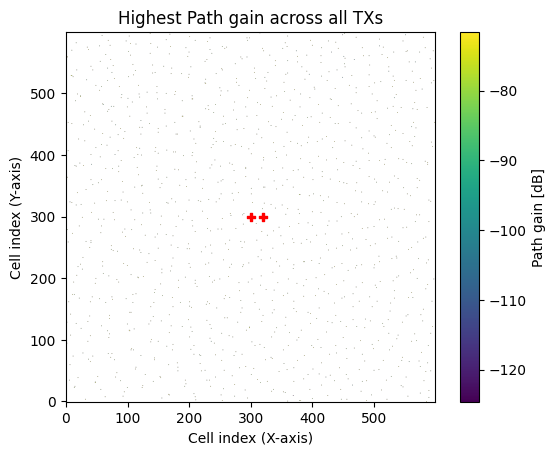

In [ ]:
pos0 = [0,0, 150]
pos1 = [20, 0, 200]


scene = load_scene(sionna.rt.scene.etoile)

scene.tx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            pattern="iso",
                            polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                            num_cols=1,
                            pattern="iso",
                            polarization="V")

cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))

tx0 = Transmitter(name='tx0',
                  position=pos0,
                  orientation=[0, 0, 0])

tx1 = Transmitter(name='tx1',
                  position=pos1,
                  orientation=[0, 0, 0])



scene.add(tx0)
scene.add(tx1)

rm_solver = RadioMapSolver()

rm_etoile = rm_solver(scene,
                      center=[0,0,1000],
                      orientation=[0,0,0],
                      size=[600,600],
                      max_depth=20,
                      samples_per_tx=nb_samples,
                      refraction=False,
                      cell_size=(1, 1))

rm_etoile.show(metric="path_gain")
print(rm_etoile.path_gain.shape)
map_size = rm_etoile.path_gain.shape[1:][1], rm_etoile.path_gain.shape[1:][0]
map_width, map_height = map_size
print(map_size)
map_center = (map_width//2, map_height//2, 1.5)

In [ ]:
scene.frequency

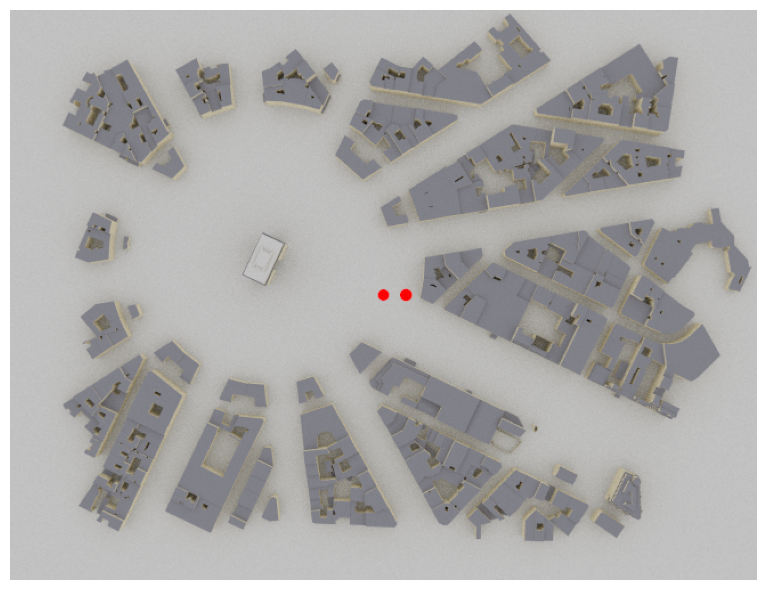

In [ ]:
scene.render(camera=cam,
                    radio_map=rm_etoile,
                    rm_metric="path_gain")

print()

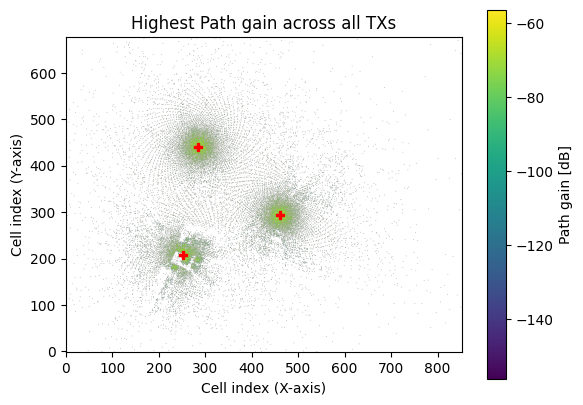

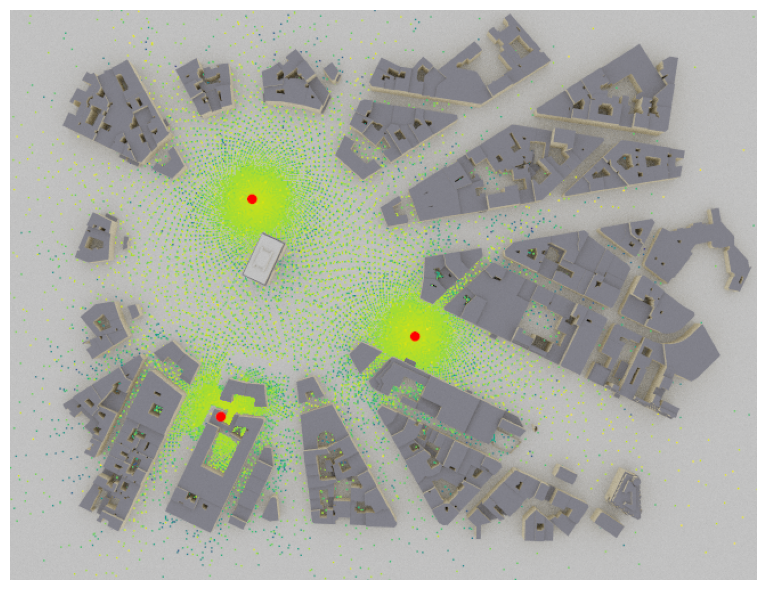

In [ ]:
tx_positions = np.array([[-150.3, 21.63, 42.5],
                        [-125.1, 9.58, 42.5],
                        [-104.5, 54.94, 42.5],
                        [-128.6, 66.73, 42.5],
                        [172.1, 103.7, 24],
                        [232.8, -95.5, 17],
                        [80.1, 193.8, 21]])

scene_i = load_scene(sionna.rt.scene.etoile)
scene_i.tx_array = scene.tx_array
scene_i.rx_array = scene.rx_array

tx_positions = np.array([ [33.94, -44.60, 30.0],
                          [-141.24, 103.20, 30.0],
                          [-175, -131, 30]])

for i, pos in enumerate(tx_positions):
    tx = Transmitter(name=f"tx{i}", position=pos, orientation=[0, 0, 0])
    scene_i.add(tx)

rm = rm_solver(scene=scene_i,
                max_depth=20,
                samples_per_tx=nb_samples,
                cell_size=(1, 1))

rm.show(metric="path_gain")

scene_i.render(camera=cam,
                    radio_map=rm,
                    rm_metric="path_gain")

print()

# Empty scene

In [ ]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

# Define and add a first transmitter to the scene
tx0 = Transmitter(name='tx0',
                  position=[150, -100, 20],
                  orientation=[0, 0, 0],
                  power_dbm=44)
scene.add(tx0)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[400, 400],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

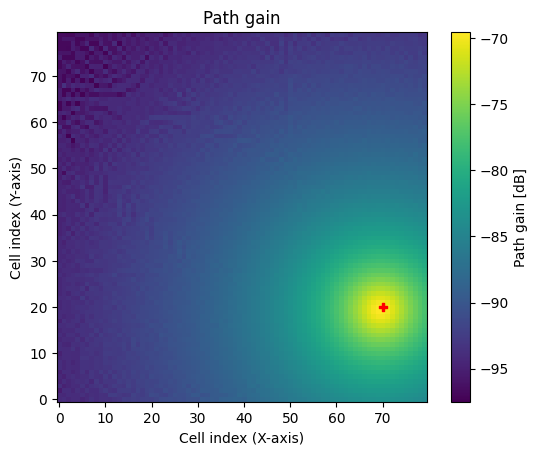

In [ ]:
# Visualize path gain
rm.show(metric="path_gain");

In [ ]:
# Metrics have the shape [num_tx, num_cells_y, num_cells_x]
print(f'{rm.path_gain.shape=}') # Path gain

# location of all cell centers: [num_cells_y, num_cells_x, 3]
print(f'{rm.cell_centers.shape=}')

rm.path_gain.shape=(1, 80, 80)
rm.cell_centers.shape=(80, 80, 3)


In [ ]:
torch_loss = rm.path_gain.torch()
test_np = rm.path_gain.numpy()

In [ ]:
print(torch_loss)
print(rm.path_gain)
print(test_np)

tensor([[[3.8003e-10, 4.1643e-10, 3.6977e-10,  ..., 4.0948e-09,
          3.9415e-09, 3.8234e-09],
         [3.7830e-10, 3.7359e-10, 4.0955e-10,  ..., 4.4549e-09,
          4.3345e-09, 4.1653e-09],
         [2.9338e-10, 4.1309e-10, 4.0728e-10,  ..., 4.9273e-09,
          4.6824e-09, 4.5157e-09],
         ...,
         [2.1075e-10, 2.0889e-10, 2.0706e-10,  ..., 5.7677e-10,
          5.4404e-10, 5.1160e-10],
         [2.1287e-10, 2.6329e-10, 2.6065e-10,  ..., 5.8651e-10,
          5.1874e-10, 5.2004e-10],
         [2.1406e-10, 2.1214e-10, 2.1025e-10,  ..., 5.2660e-10,
          4.5675e-10, 4.9356e-10]]])
[[[3.80027e-10, 4.16432e-10, 3.69769e-10, .. 74 skipped .., 4.09482e-09, 3.94148e-09, 3.82344e-09],
  [3.78303e-10, 3.73587e-10, 4.09554e-10, .. 74 skipped .., 4.45488e-09, 4.33447e-09, 4.16534e-09],
  [2.93384e-10, 4.1309e-10, 4.07283e-10, .. 74 skipped .., 4.92727e-09, 4.68239e-09, 4.51572e-09],
  .. 74 skipped ..,
  [2.10747e-10, 2.08887e-10, 2.07059e-10, .. 74 skipped .., 5.76772e-10

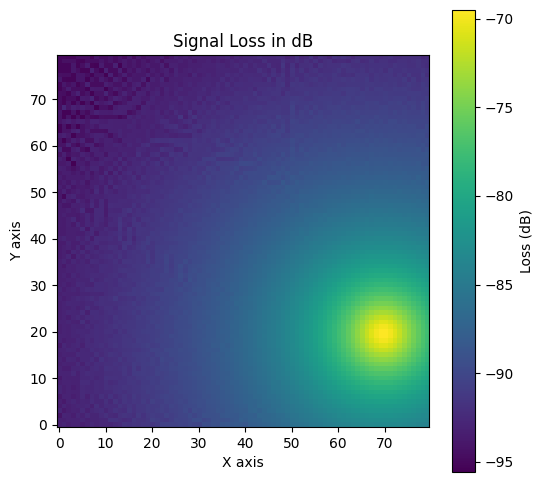

In [ ]:
eps = 1e-10
loss_db = 10 * np.log10(test_np[0] + eps)
plt.figure(figsize=(6, 6))
plt.imshow(loss_db, origin='lower')
plt.colorbar(label='Loss (dB)')
plt.title('Signal Loss in dB')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


# Benchmark

In [ ]:
samples = [10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6, 5*10**6, 10**7, 5*10**7, 10**8, 5*10**8, 10**9]
exec_time = []
for nb_sample in samples:
    start_time = time.time()
    rm_etoile3 = rm_solver(scene,
                      max_depth=20,
                      samples_per_tx=nb_sample,
                      cell_size=(1, 1))

    rm_etoile3.show(metric="path_gain")
    end_time = time.time()
    print(f"Temps d'exécution pour {nb_sample} échantillons : {end_time - start_time} secondes")
    exec_time.append(end_time - start_time)


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(samples, exec_time, marker='o')  # Use marker='o' to show data points
plt.xscale('log')  # Use log scale for the x-axis
plt.yscale('log')  # Use log scale for the x-axis
plt.xlabel('Number of Samples')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs. Number of Samples (Radio Map Solver)')
plt.grid(True)
plt.show()

In [ ]:
samples = [10**3, 5*10**3, 10**4, 5*10**4, 10**5, 5*10**5, 10**6, 5*10**6, 10**7, 5*10**7, 10**8, 5*10**8, 10**9]
exec_time = []
for nb_sample in samples:
    start_time = time.time()
    rm_etoile3 = rm_solver(scene,
                      max_depth=200,
                      samples_per_tx=nb_sample,
                      cell_size=(1, 1))

    rm_etoile3.show(metric="path_gain")
    end_time = time.time()
    print(f"Temps d'exécution pour {nb_sample} échantillons : {end_time - start_time} secondes")
    exec_time.append(end_time - start_time)


In [ ]:
sizes = [10,50,100,200,300,400,500,600]
exec_time = []
for map_size in sizes:
    start_time = time.time()
    rm_etoile3 = rm_solver(scene,
                      max_depth=20,
                      samples_per_tx=10**8,
                      cell_size=(1, 1),
                      center = (0,0,1.5),
                      orientation = (0,0,0),
                      size=(map_size,map_size))

    rm_etoile3.show(metric="path_gain")
    end_time = time.time()
    print(f"{map_size} : {end_time - start_time} secondes")
    exec_time.append(end_time - start_time)


# Map feature extraction

In [ ]:
vertices = []

for obj in scene.objects:
    shape = scene.get(obj).mi_mesh
    nb_vertices = shape.vertex_count()
    for i in range(nb_vertices):
        x, y, z = shape.vertex_position(i)
        vertices.append((x, y, z))
vertices = np.array(vertices)
print(vertices.shape)

(14193, 3, 1)


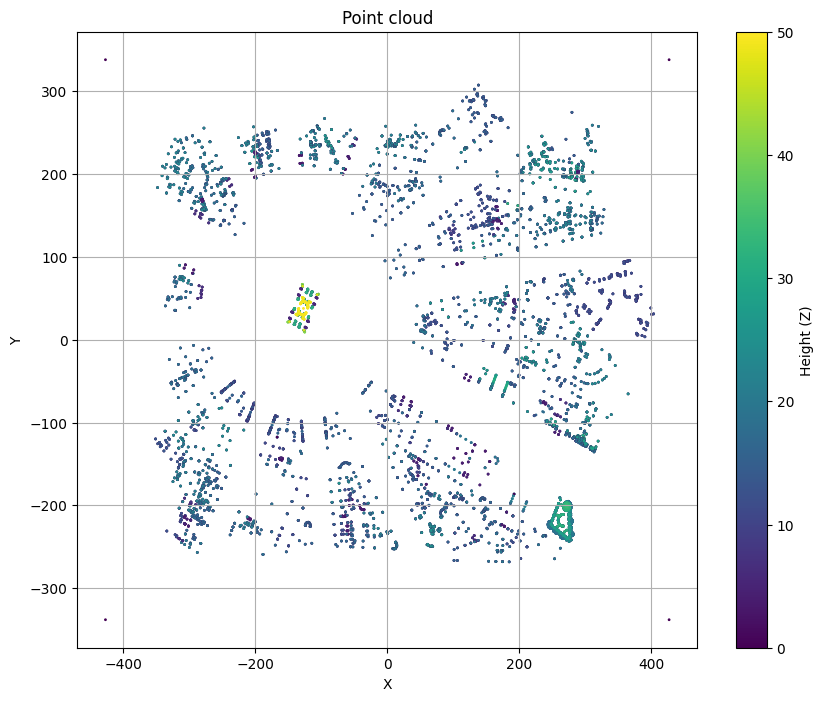

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(vertices[:, 0], vertices[:, 1], c=vertices[:, 2], cmap='viridis', s=1)
plt.colorbar(label='Height (Z)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point cloud')
plt.grid(True)
plt.show()

/tmp/ipython-input-829567866.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  col = int((y - min_y) / (max_y - min_y) * (num_cells_y - 1))
/tmp/ipython-input-829567866.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lig = int((x - min_x) / (max_x - min_x) * (num_cells_x - 1))
/tmp/ipython-input-829567866.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  height_map[col, lig] = max(z, height_map[col, lig])


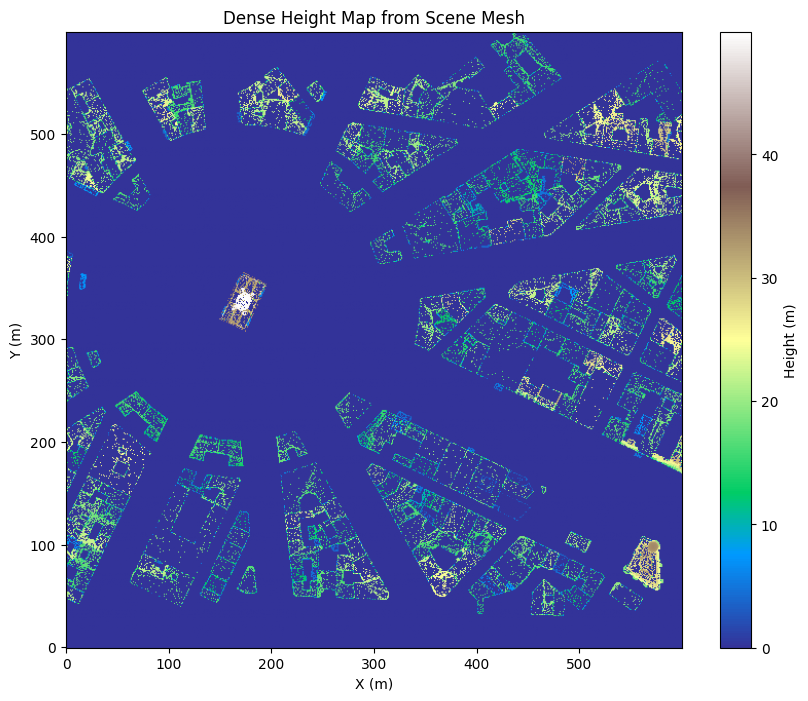

In [ ]:
def sample_points_in_triangle(v0, v1, v2, n_samples=10):
    points = []
    for _ in range(n_samples):
        u = np.random.rand()
        v = np.random.rand()
        if u + v > 1:
            u, v = 1 - u, 1 - v
        w = 1 - u - v
        point = u * v0 + v * v1 + w * v2
        points.append(point)
    return np.array(points)

def create_dense_height_map(scene, map_size=(900, 800), n_samples_per_face=10000):
    num_cells_x, num_cells_y = map_size
    height_map = np.zeros((num_cells_y, num_cells_x))
    min_x, max_x = -num_cells_x // 2, num_cells_x // 2
    min_y, max_y = -num_cells_y // 2, num_cells_y // 2

    for obj in scene.objects:
        shape = scene.get(obj).mi_mesh
        nb_faces = shape.face_count()
        for f in range(nb_faces):
            idx0, idx1, idx2 = shape.face_indices(f)
            v0 = shape.vertex_position(idx0).numpy()
            v1 = shape.vertex_position(idx1).numpy()
            v2 = shape.vertex_position(idx2).numpy()
            points = sample_points_in_triangle(v0, v1, v2, n_samples=n_samples_per_face)
            for x, y, z in points:
                col = int((y - min_y) / (max_y - min_y) * (num_cells_y - 1))
                lig = int((x - min_x) / (max_x - min_x) * (num_cells_x - 1))
                if 0 <= col < num_cells_y and 0 <= lig < num_cells_x:
                    height_map[col, lig] = max(z, height_map[col, lig])
    return height_map

height_map = create_dense_height_map(scene, map_size=map_size, n_samples_per_face=10)

plt.figure(figsize=(10, 8))
plt.imshow(height_map, origin='lower', cmap='terrain')
plt.colorbar(label='Height (m)')
plt.title('Dense Height Map from Scene Mesh')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

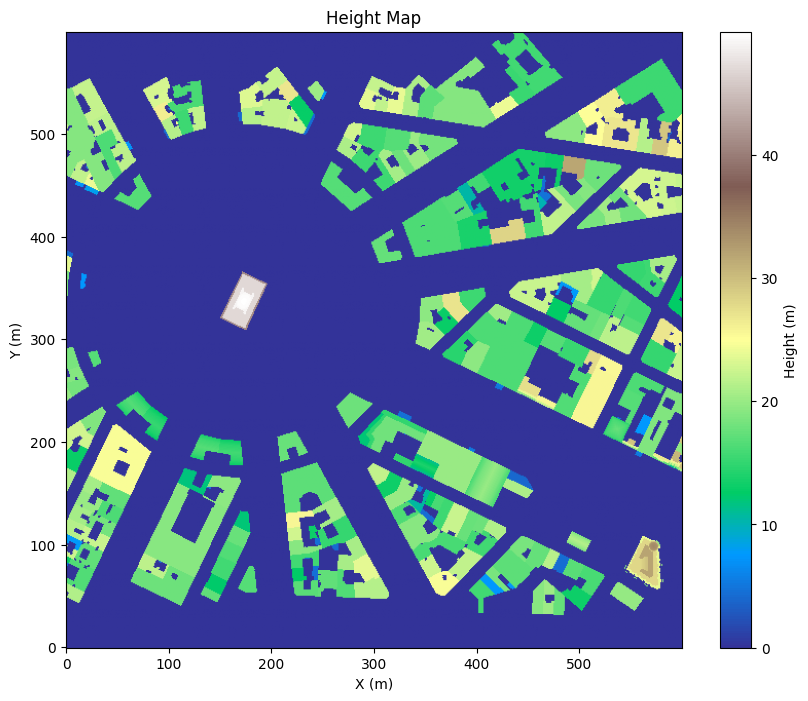

In [ ]:
def create_perfect_height_map_mitsuba_vectorized(scene, map_size=(400, 400), cell_size=(1, 1), height=1000):
    mi_scene = scene.mi_scene
    num_cells_x = int(map_size[0] / cell_size[0])
    num_cells_y = int(map_size[1] / cell_size[1])
    x_coords = np.linspace(-map_size[0]//2, map_size[0]//2, num_cells_x, dtype=np.float32)
    y_coords = np.linspace(-map_size[1]//2, map_size[1]//2, num_cells_y, dtype=np.float32)
    X, Y = np.meshgrid(x_coords, y_coords)
    # Shape should be (3, N)
    origins = mi.Point3f(np.stack([
        X.ravel(), Y.ravel(), np.full(X.size, height, dtype=np.float32)
    ], axis=0))
    directions = mi.Vector3f(np.tile([[0.0], [0.0], [-1.0]], (1, X.size)))
    rays = mi.Ray3f(origins, directions)
    sis = mi_scene.ray_intersect(rays)
    z = np.where(sis.is_valid(), sis.p.z, 0.0)
    height_map = np.array(z).reshape((num_cells_y, num_cells_x))
    return height_map, x_coords, y_coords


height_map, x_coords, y_coords = create_perfect_height_map_mitsuba_vectorized(scene, map_size=map_size)
plt.figure(figsize=(10, 8))
plt.imshow(height_map, origin='lower', cmap='terrain')
plt.colorbar(label='Height (m)')
plt.title('Height Map')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

/tmp/ipython-input-2754703614.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(height_map_scaled, 'L')


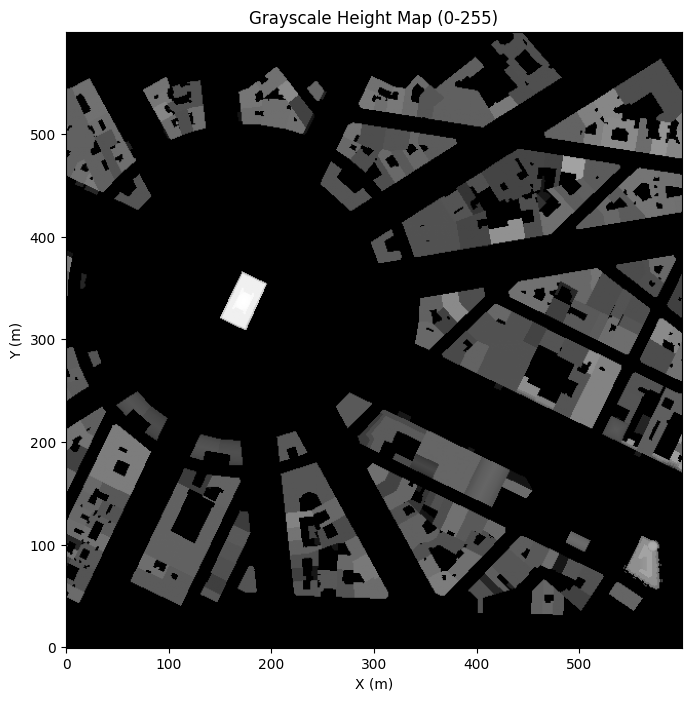

In [ ]:
height_map_scaled = (height_map / 50  * 255).astype(np.uint8)

img = Image.fromarray(height_map_scaled, 'L')
plt.figure(figsize=(10, 8))
plt.imshow(img, origin='lower', cmap='gray')
plt.title('Grayscale Height Map (0-255)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

In [ ]:
img.save("height_map.png")

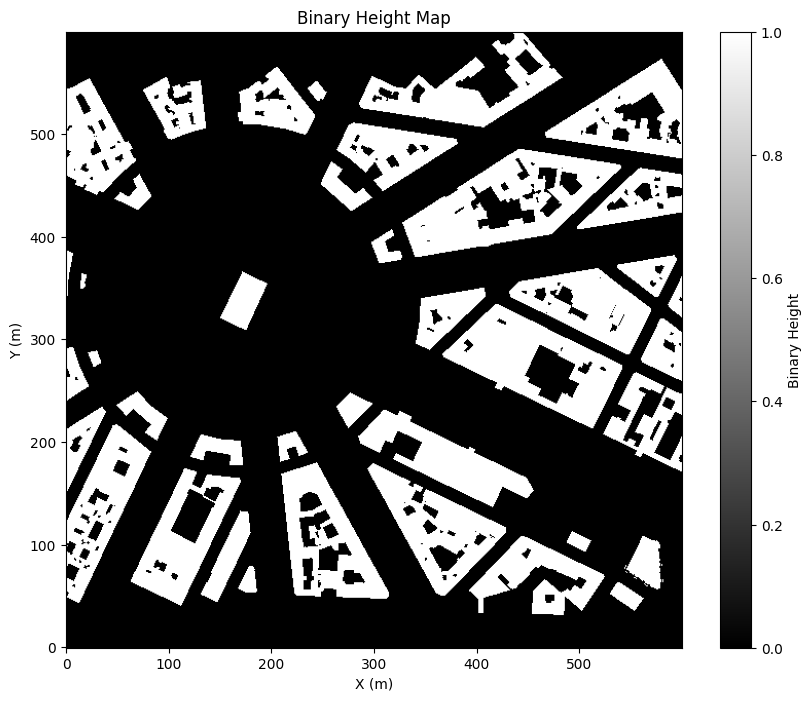

In [ ]:
binary_height_map = (height_map > 0).astype(int)

plt.figure(figsize=(10, 8))
plt.imshow(binary_height_map, origin='lower', cmap='gray')
plt.colorbar(label='Binary Height')
plt.title('Binary Height Map')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

# Crop definitions

In [ ]:
def generate_random_points(num_points, map_width, map_height, padding):
    x_min = 0
    x_max = map_width - padding
    y_min = 0
    y_max = map_height - padding

    if x_min > x_max or y_min > y_max:
        raise ValueError("Padding is too large for the given map size.")

    centers = np.zeros((num_points, 2), dtype=int)
    centers[:, 0] = np.random.randint(x_min, x_max, num_points, dtype=int)
    centers[:, 1] = np.random.randint(y_min, y_max, num_points, dtype=int)

    return centers

def center_crop(map_data, crop_size=256, centerX=0, centerY=0):
    start_y = centerY
    end_y = start_y + crop_size
    start_x = centerX
    end_x = start_x + crop_size

    cropped_map = map_data[start_y:end_y, start_x:end_x]
    return cropped_map

In [ ]:
map_patch_size = 256
num_random_centers = 500
square_size = 80

random_centers = generate_random_points(num_random_centers, map_width, map_height, map_patch_size)
random_squares = generate_random_points(num_random_centers, map_patch_size, map_patch_size, square_size)

print(random_centers)
print(random_squares)

In [ ]:
np.savetxt('random_centers.txt', random_centers)
np.savetxt('random_squares.txt', random_squares)

In [ ]:
center_id = 0
random_centers = np.loadtxt('random_centers.txt').astype(int)
random_squares = np.loadtxt('random_squares.txt').astype(int)

print(random_centers)
print(random_squares)

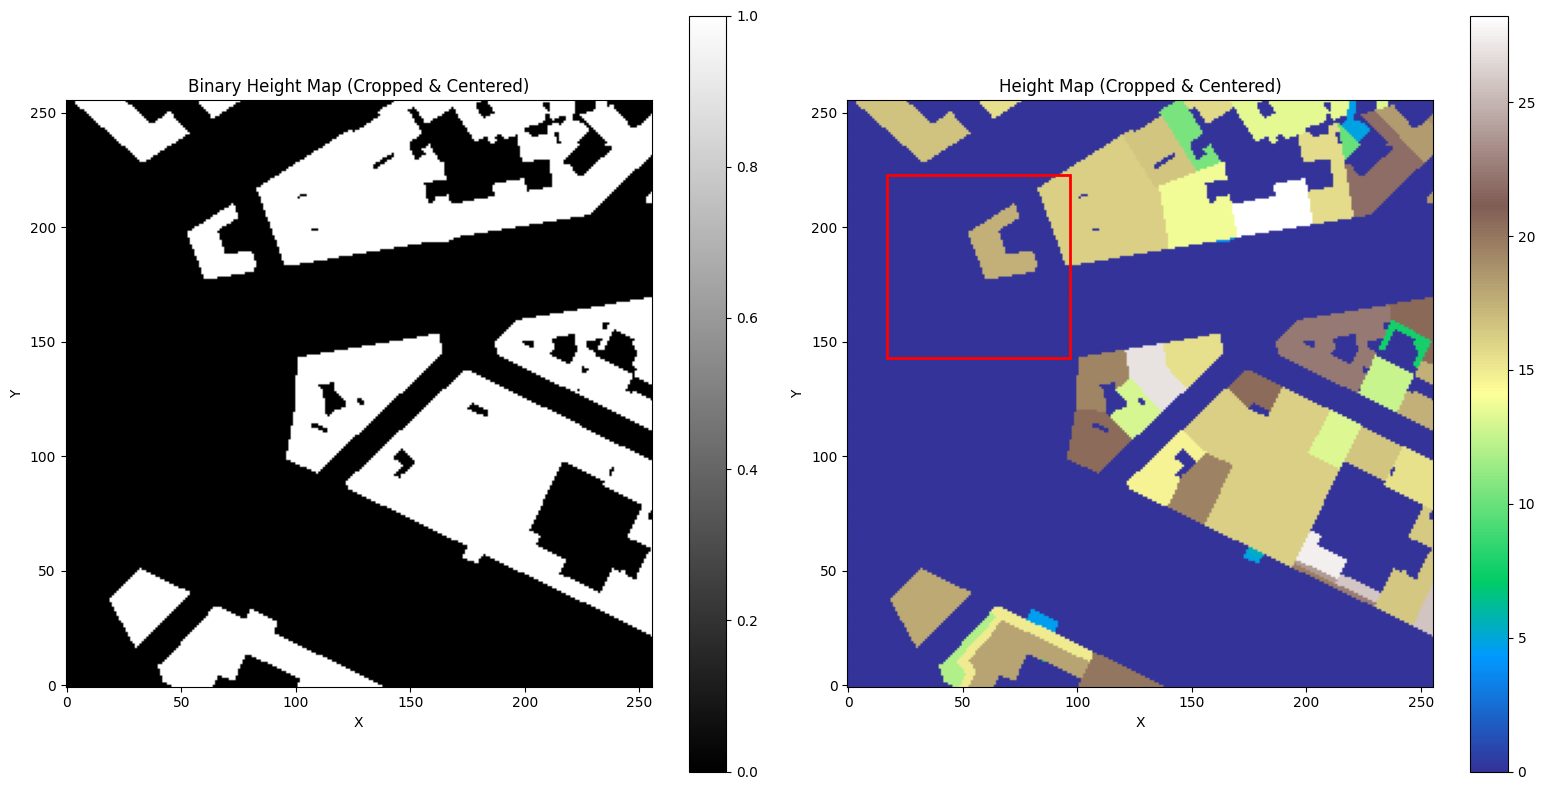

Binary height map shape (Centered): (256, 256)
Height map shape (Centered): (256, 256)
Center coordinates (Centered): 244, 197
Square center coordinates (Centered): 17, 143


In [ ]:
random_center_x = random_centers[center_id, 0]
random_center_y = random_centers[center_id, 1]

square_origin =  random_squares[center_id]
square_center_x = square_origin[0]
square_center_y = square_origin[1]

binary_height_map_cropped = center_crop(binary_height_map, 256, centerX=random_center_x, centerY=random_center_y)
height_map_cropped = center_crop(height_map, 256, centerX=random_center_x, centerY=random_center_y)

# Visualize the cropped maps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot binary height map
im1 = axes[0].imshow(binary_height_map_cropped, origin='lower', cmap='gray')
axes[0].set_title('Binary Height Map (Cropped & Centered)')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(im1, ax=axes[0])

# Plot height map
im2 = axes[1].imshow(height_map_cropped, origin='lower', cmap='terrain')
axes[1].set_title('Height Map (Cropped & Centered)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(im2, ax=axes[1])


rect = plt.Rectangle((square_center_x, square_center_y), square_size, square_size,
                     linewidth=2, edgecolor='r', facecolor='none')

plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()

print(f"Binary height map shape (Centered): {binary_height_map_cropped.shape}")
print(f"Height map shape (Centered): {height_map_cropped.shape}")
print(f"Center coordinates (Centered): {random_center_x}, {random_center_y}")
print(f"Square center coordinates (Centered): {square_center_x}, {square_center_y}")

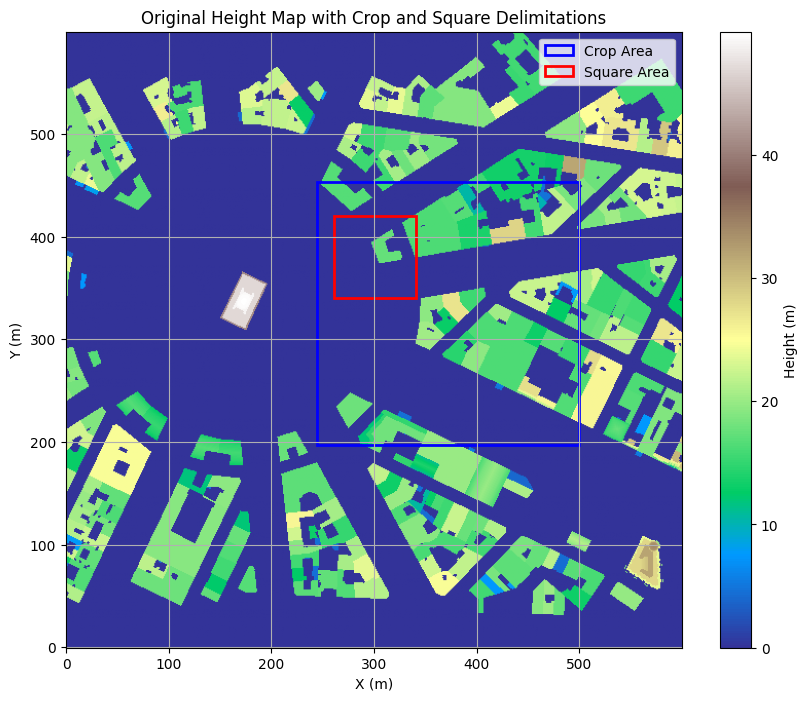

In [ ]:
crop_x_start_orig = random_center_x
crop_y_start_orig = random_center_y
crop_x_end_orig = crop_x_start_orig + map_patch_size
crop_y_end_orig = crop_y_start_orig + map_patch_size

square_x_start_orig = crop_x_start_orig + square_center_x
square_y_start_orig = crop_y_start_orig + square_center_y
square_x_end_orig = square_x_start_orig + square_size
square_y_end_orig = square_y_start_orig + square_size


plt.figure(figsize=(10, 8))

# Plot the original height map
plt.imshow(height_map, origin='lower', cmap='terrain')
plt.colorbar(label='Height (m)')
plt.title('Original Height Map with Crop and Square Delimitations')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

# Add the rectangle delimiting the crop region on the original map
crop_rect_orig = plt.Rectangle((crop_x_start_orig, crop_y_start_orig), map_patch_size, map_patch_size,
                             linewidth=2, edgecolor='blue', facecolor='none', label='Crop Area')
plt.gca().add_patch(crop_rect_orig)

# Add the rectangle delimiting the square region on the original map
square_rect_orig = plt.Rectangle((square_x_start_orig, square_y_start_orig), square_size, square_size,
                                 linewidth=2, edgecolor='red', facecolor='none', label='Square Area')
plt.gca().add_patch(square_rect_orig)

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
output_dir = "/point_cloud"
os.makedirs(output_dir, exist_ok=True)


for center_id in range(len(random_centers)):
  vertices_in_crop = []


  random_center_x = random_centers[center_id, 0]
  random_center_y = random_centers[center_id, 1]

  crop_x_start_orig = random_center_x
  crop_y_start_orig = random_center_y
  crop_x_end_orig = crop_x_start_orig + map_patch_size
  crop_y_end_orig = crop_y_start_orig + map_patch_size



  print(crop_x_start_orig, crop_x_end_orig, crop_y_start_orig, crop_y_end_orig)

  for vertex in vertices:
      x, y, z = vertex[0] + map_center[0], vertex[1] + map_center[1], vertex[2]
      x,y,z = x.item(), y.item(), z.item()
      if crop_x_start_orig <= x < crop_x_end_orig and crop_y_start_orig <= y < crop_y_end_orig:
          x = x - crop_x_start_orig
          y = y - crop_y_start_orig
          vertices_in_crop.append((x, y, z))

  print(f"Number of vertices inside the crop: {len(vertices_in_crop)}")
  # save the array in a file name center_id.txt
  np.savetxt(os.path.join(output_dir, f'{center_id}.txt'), vertices_in_crop)

244 500 197 453
Number of vertices inside the crop: 1478


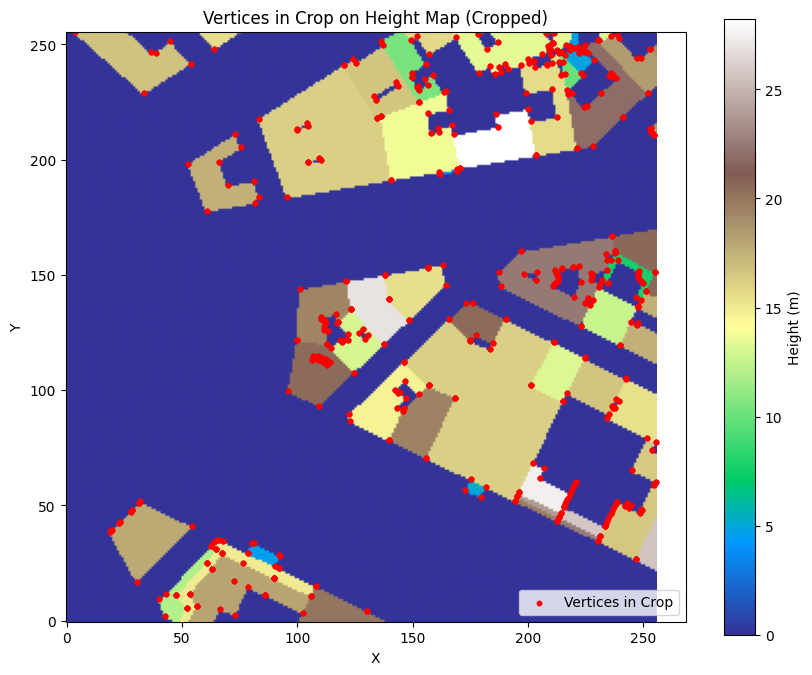

In [ ]:
vertices_in_crop_np = np.array(vertices_in_crop)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(height_map_cropped, origin='lower', cmap='terrain')
fig.colorbar(im, ax=ax, label='Height (m)')

if len(vertices_in_crop_np) > 0:
    adjusted_x = vertices_in_crop_np[:, 0]
    adjusted_y = vertices_in_crop_np[:, 1]
    ax.scatter(adjusted_x, adjusted_y, c='red', s=10, label='Vertices in Crop')

ax.set_title('Vertices in Crop on Height Map (Cropped)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

In [ ]:
binary_img = Image.fromarray((binary_height_map_cropped * 255).astype(np.uint8), 'L')
binary_img.save(str(center_id) + '.png')
print("Binary height saved")

norm = mpl.colors.Normalize(vmin=height_map_cropped.min(), vmax=height_map_cropped.max())
cmap = colormaps['terrain']
colored_height_map = cmap(norm(height_map_cropped))

height_img = Image.fromarray((colored_height_map * 255).astype(np.uint8))
height_img.save('height_map.png')
print("Height map saved as height_map_cropped.png")

Binary height saved
Height map saved as height_map_cropped.png


# Generate train / test positions

In [ ]:
train_file_positions = [ [] for i in range(num_random_centers)]
test_file_positions = [ [] for i in range(num_random_centers)]

try:
    with open('tx_train_positions.json', 'r') as f:
        train_file_positions = json.load(f)
except FileNotFoundError:
    print("tx_train_positions.json not found.")
except json.JSONDecodeError:
    print("Error decoding tx_train_positions.json.")

try:
    with open('tx_test_positions.json', 'r') as f:
        test_file_positions = json.load(f)
except FileNotFoundError:
    print("tx_test_positions.json not found.")
except json.JSONDecodeError:
    print("Error decoding tx_test_positions.json.")

def generate_locations(num_points, region, square_origin, square_size, z_value, range):
      x_min, y_min = square_origin
      x_max = x_min + square_size
      y_max = y_min + square_size

      points = []
      while len(points) < num_points:
          x = np.random.uniform(0, range)
          y = np.random.uniform(0, range)
          z = z_value

          in_square = (x_min <= x <= x_max) and (y_min <= y <= y_max)

          if (region == 'train' and not in_square) or (region == 'test' and in_square):
              points.append([x, y, z])

      return np.array(points)

for center_id in range(num_random_centers):
  old_train_positions = train_file_positions[center_id]
  old_test_positions = test_file_positions[center_id]

  train_index = len(old_train_positions)
  test_index = len(old_test_positions)

  print("Train locations:", len(old_train_positions))
  print("Test locations:", len(old_test_positions))



  z_height = 30.0
  num_train_points = 80
  num_test_points = 40

  train_positions = generate_locations(num_train_points, 'train', square_origin, square_size, z_height, map_patch_size)
  test_positions = generate_locations(num_test_points, 'test', square_origin, square_size, z_height, map_patch_size)

  old_train_positions.extend(train_positions.tolist())
  old_test_positions.extend(test_positions.tolist())

  print("Updated train locations:", len(old_train_positions))
  print("Updated test locations:", len(old_test_positions))

  train_file_positions[center_id] = old_train_positions
  test_file_positions[center_id] = old_test_positions

  with open('tx_train_positions.json', 'w') as f:
      json.dump(train_file_positions, f)

  with open('tx_test_positions.json', 'w') as f:
      json.dump(test_file_positions, f)

In [ ]:
def generate_locations(num_points, region, square_origin, square_size, z_value, range):
    x_min, y_min = square_origin
    x_max = x_min + square_size
    y_max = y_min + square_size

    points = []
    while len(points) < num_points:
        x = np.random.uniform(0, range)
        y = np.random.uniform(0, range)
        z = z_value

        in_square = (x_min <= x <= x_max) and (y_min <= y <= y_max)

        if (region == 'train' and not in_square) or (region == 'test' and in_square):
            points.append([x, y, z])

    return np.array(points)

z_height = 30.0
num_train_points = 80
num_test_points = 40

train_positions = generate_locations(num_train_points, 'train', square_origin, square_size, z_height, map_patch_size)
test_positions = generate_locations(num_test_points, 'test', square_origin, square_size, z_height, map_patch_size)

old_train_positions.extend(train_positions.tolist())
old_test_positions.extend(test_positions.tolist())

print("Updated train locations:", len(old_train_positions))
print("Updated test locations:", len(old_test_positions))

train_file_positions[center_id] = old_train_positions
test_file_positions[center_id] = old_test_positions

with open('tx_train_positions.json', 'w') as f:
    json.dump(train_file_positions, f)

with open('tx_test_positions.json', 'w') as f:
    json.dump(test_file_positions, f)

Updated train locations: 80
Updated test locations: 40


# Loading train / test positions

In [ ]:
train_file_positions = [ [] for i in range(num_random_centers)]
test_file_positions = [ [] for i in range(num_random_centers)]

z_height = 30.0
num_train_points = 80
num_test_points = 40

try:
    with open('tx_train_positions.json', 'r') as f:
        train_file_positions = json.load(f)
except FileNotFoundError:
    print("tx_train_positions.json not found.")
except json.JSONDecodeError:
    print("Error decoding tx_train_positions.json.")

try:
    with open('tx_test_positions.json', 'r') as f:
        test_file_positions = json.load(f)
except FileNotFoundError:
    print("tx_test_positions.json not found.")
except json.JSONDecodeError:
    print("Error decoding tx_test_positions.json.")

train_positions = np.array(train_file_positions[center_id])
test_positions = np.array(test_file_positions[center_id])

train_index = 0
test_index = 0

print("Train locations:", len(train_positions))
print("Test locations:", len(test_positions))

Train locations: 80
Test locations: 40


In [ ]:
train_positions = train_positions[:2]
test_positions = test_positions[:2]

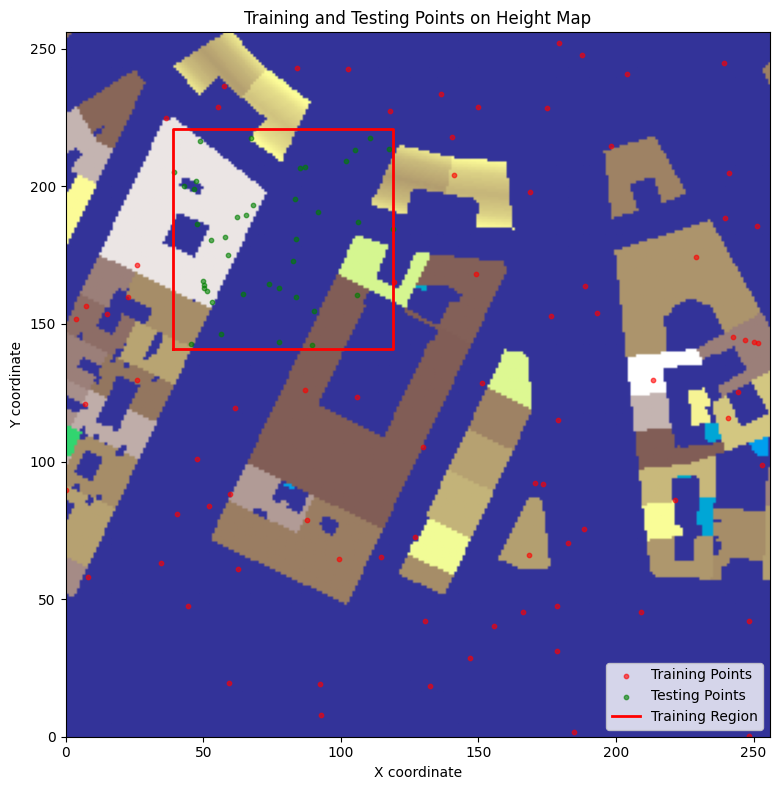

In [ ]:
import matplotlib.image as mpimg

image_size = height_map_cropped.shape  # (H, W)
img_width = image_size[1]
img_height = image_size[0]
x_range = (0, 256)
y_range = (0, 256)

def plot_points_on_heightmap(train_data, test_data, square_origin, square_size, height_map_path):
    # Charger l'image RGB
    height_map_img = mpimg.imread(height_map_path)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(height_map_img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')

    ax.scatter(train_data[:, 0], train_data[:, 1], c='red', s=10, label='Training Points', alpha=0.6)
    ax.scatter(test_data[:, 0], test_data[:, 1], c='green', s=10, label='Testing Points', alpha=0.6)

    x_min, y_min = square_origin
    x_max = x_min + square_size
    y_max = y_min + square_size

    ax.plot(
        [x_min, x_max, x_max, x_min, x_min],
        [y_min, y_min, y_max, y_max, y_min],
        c='red', linewidth=2, label='Training Region'
    )

    ax.set_title("Training and Testing Points on Height Map")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.legend()
    ax.grid(False)
    plt.tight_layout()
    plt.show()

plot_points_on_heightmap(train_positions, test_positions, square_origin, square_size, 'height_map.png')

In [ ]:
def generate_radio_maps(tx_positions, nb_samples, centerX, centerY, map_size):
    radio_maps = []
    base_scene = load_scene(sionna.rt.scene.etoile)
    base_scene.tx_array = scene.tx_array
    base_scene.rx_array = scene.rx_array

    for i, pos in enumerate(tx_positions):
        scene_i = base_scene

        for tx_name in list(scene_i.transmitters.keys()):
            scene_i.remove(tx_name)
            print(tx_name)

        globalX = pos[0] + random_center_x - map_size[0] // 2
        globalY = pos[1] + random_center_y - map_size[1] // 2

        posX = float(globalX)
        posY = float(globalY)
        pos = [posX, posY, float(pos[2])]

        tx = Transmitter(name=f"tx{i}", position=pos, orientation=[0, 0, 0])
        scene_i.add(tx)

        rm = rm_solver(scene=scene_i,
                      max_depth=4,
                      samples_per_tx=nb_samples,
                      cell_size=(1, 1))

        #rm.show(metric="path_gain")
        #scene_i.render(camera=cam, radio_map=rm, rm_metric="path_gain")

        radio_maps.append(rm)

    return radio_maps

radio_maps = generate_radio_maps(train_positions, nb_samples, random_center_x, random_center_y, map_size)
test_radio_maps = generate_radio_maps(test_positions, nb_samples, random_center_x, random_center_y, map_size)

Number of cropped maps: 80
Shape of the first cropped map: (256, 256)


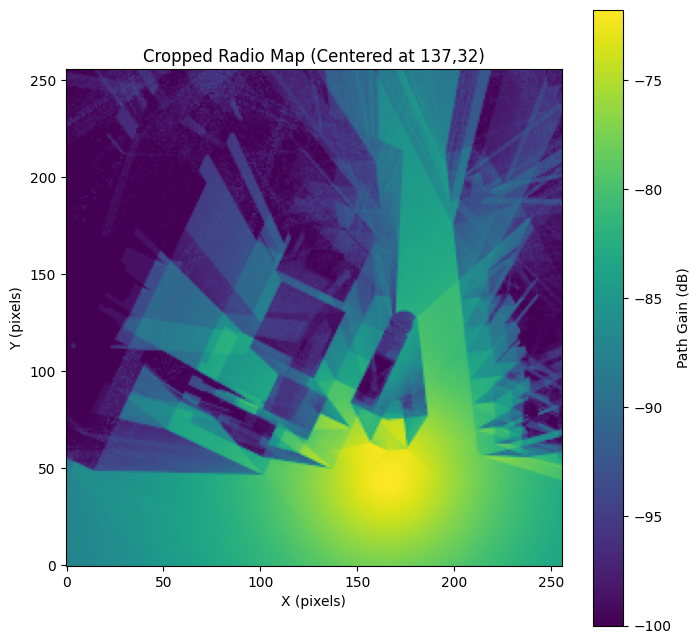

In [ ]:
def crop_around_center(radio_maps, centerX, centerY, map_size, crop_size=256):
    cropped_maps = []

    for rm in radio_maps:
        path_gain_np = rm.path_gain.numpy()[0]

        cropped_map = center_crop(path_gain_np, crop_size=256, centerX=centerX, centerY=centerY)
        cropped_maps.append(cropped_map)

    return cropped_maps

crop_size = 256

cropped_radio_maps = crop_around_center(radio_maps, random_center_x, random_center_y, map_size, crop_size)
cropped_test_radio_maps = crop_around_center(test_radio_maps, random_center_x, random_center_y, map_size, crop_size)

print(f"Number of cropped maps: {len(cropped_radio_maps)}")
print(f"Shape of the first cropped map: {cropped_radio_maps[0].shape}")

plt.figure(figsize=(8, 8))

cropped_map_db = 10 * np.log10(cropped_radio_maps[0] + 1e-10)
plt.imshow(cropped_map_db, origin='lower', cmap='viridis')
plt.colorbar(label='Path Gain (dB)')
plt.title(f'Cropped Radio Map (Centered at {random_center_x},{random_center_y})')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()

In [ ]:
def path_gain_map(radio_maps):
    path_gain_db_arrays = []

    for i, path_gain in enumerate(radio_maps):
        path_gain_magnitude = np.abs(path_gain)
        path_gain_magnitude[path_gain_magnitude == 0] = np.nan
        path_gain_db = 10 * np.log10(path_gain_magnitude)

        path_gain_db_arrays.append(path_gain_db)

    return path_gain_db_arrays

path_gain_db_arrays = path_gain_map(cropped_radio_maps)
path_gain_db_arrays_test = path_gain_map(cropped_test_radio_maps)

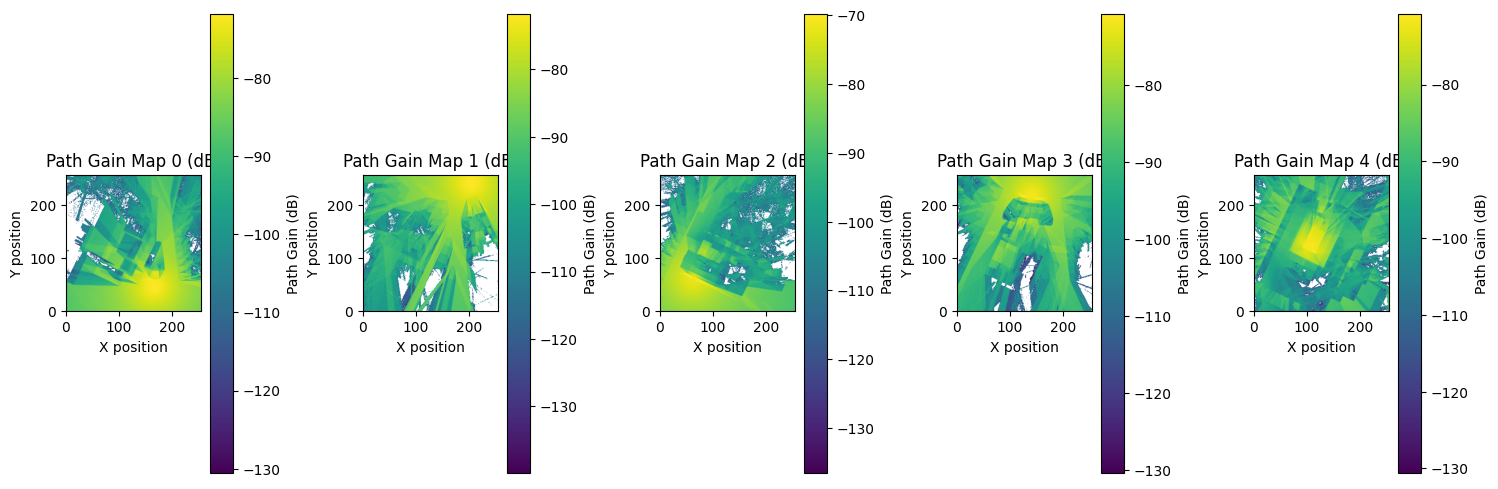

In [ ]:
fig, axes = plt.subplots(1, min(5, len(path_gain_db_arrays)), figsize=(15, 5))

for i, path_gain_db in enumerate(path_gain_db_arrays[:5]):
    fig.patch.set_facecolor('white')
    axes[i].set_facecolor('white')
    cmap = plt.cm.viridis.copy()
    cmap.set_bad('white')

    im = axes[i].imshow(path_gain_db, cmap=cmap, origin='lower')
    axes[i].set_title(f'Path Gain Map {i} (dB)')
    axes[i].set_xlabel('X position')
    axes[i].set_ylabel('Y position')
    plt.colorbar(im, ax=axes[i], label='Path Gain (dB)')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_path_gain_arrays(path_gain_db_arrays):
    min_range = -140.0
    max_range = -50.0
    range_span = max_range - min_range

    for i in range(len(path_gain_db_arrays)):
        path_gain_db_arrays[i] = np.where(binary_height_map_cropped == 1, np.nan, path_gain_db_arrays[i])

        path_gain_db_arrays[i] = np.nan_to_num(path_gain_db_arrays[i], nan=min_range)
        path_gain_db_arrays[i] = np.clip(path_gain_db_arrays[i], a_min=min_range, a_max=None)


    normalized_path_gain_arrays_fixed_range = []

    for i in range(len(path_gain_db_arrays)):
        normalized_array = (path_gain_db_arrays[i] - min_range) / range_span * 255
        normalized_array = np.clip(normalized_array, 0, 255)
        normalized_array = normalized_array.astype(np.uint8)
        normalized_path_gain_arrays_fixed_range.append(normalized_array)

    return normalized_path_gain_arrays_fixed_range

normalized_path_gain_arrays_fixed_range = preprocess_path_gain_arrays(path_gain_db_arrays)
normalized_path_gain_arrays_fixed_range_test = preprocess_path_gain_arrays(path_gain_db_arrays_test)


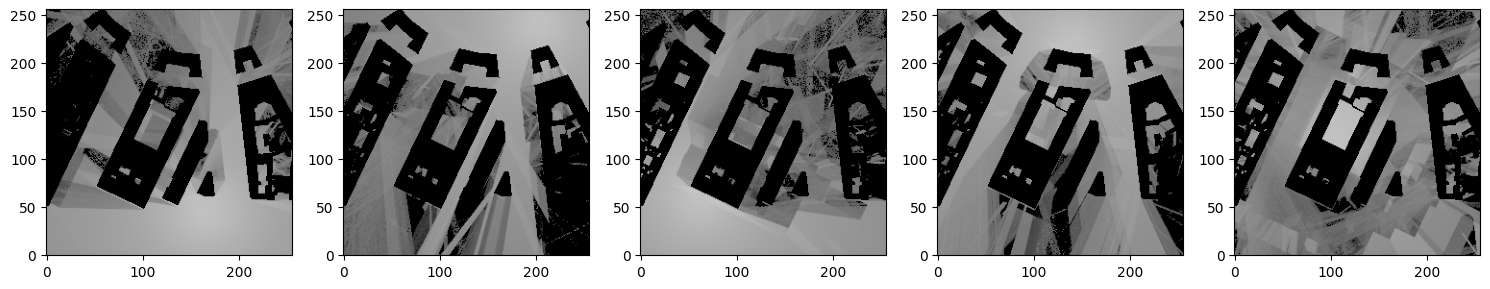

In [ ]:
fig, axes = plt.subplots(1, len(normalized_path_gain_arrays_fixed_range[:5]), figsize=(15, 5))

if len(normalized_path_gain_arrays_fixed_range) == 1:
    axes = [axes]

for i, normalized_map in enumerate(normalized_path_gain_arrays_fixed_range[:5]):
    fig.patch.set_facecolor('white')
    axes[i].set_facecolor('white')
    im = axes[i].imshow(normalized_map, cmap='gray', origin='lower', vmin=0, vmax=255)

plt.tight_layout()
plt.show()

In [ ]:
output_dir = "/gain"
os.makedirs(output_dir, exist_ok=True)

for i, normalized_map in enumerate(normalized_path_gain_arrays_fixed_range):
    img = Image.fromarray(normalized_map, 'L')
    img.save(os.path.join(output_dir, f'{center_id}_{train_index + i}.png'))


for i, normalized_map in enumerate(normalized_path_gain_arrays_fixed_range_test):
    img = Image.fromarray(normalized_map, 'L')
    img.save(os.path.join(output_dir, f'{center_id}_test_{test_index + i}.png'))


print(f"Saved {len(normalized_path_gain_arrays_fixed_range)} images to {output_dir}")

Saved 80 images to /content/gain


In [ ]:
def plot_tx_locations_on_black_image(tx_positions, image_size=(256, 256)):
    width, height = image_size
    images = np.zeros((len(tx_positions), height, width), dtype=np.uint8)
    for i, pos in enumerate(tx_positions):
        x, y, _ = pos
        images[i, int(y), int(x)] = 255

    return images

tx_images = plot_tx_locations_on_black_image(train_positions, image_size=(256, 256))
tx_test_images = plot_tx_locations_on_black_image(test_positions, image_size=(256, 256))

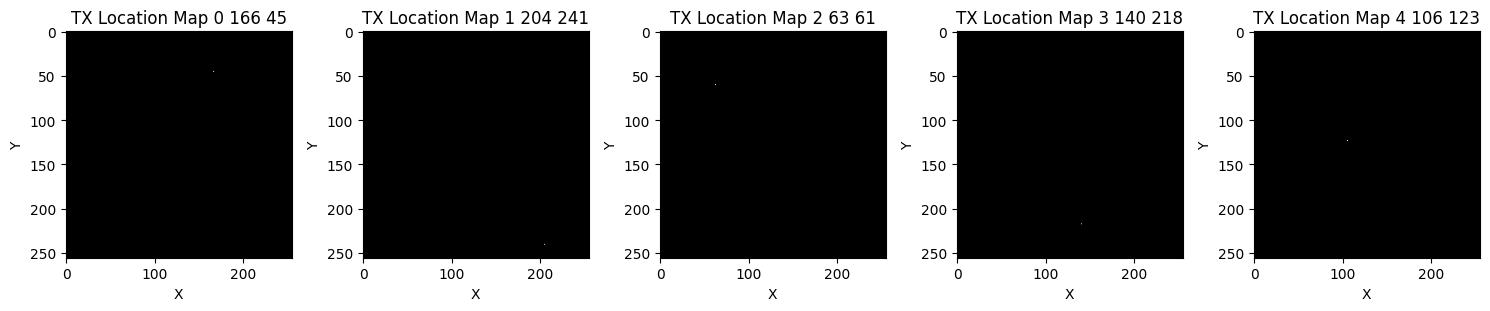

In [ ]:
fig, axes = plt.subplots(1, len(tx_images[:5]), figsize=(15, 5))

if len(tx_images) == 1:
    axes = [axes]

for i, tx_image in enumerate(tx_images[:5]):
    fig.patch.set_facecolor('white')
    axes[i].set_facecolor('black')
    im = axes[i].imshow(tx_image, cmap='gray')
    x,y, z = train_positions[i]
    x = round(x)
    y = round(y)
    axes[i].set_title(f'TX Location Map {i} {x} {y}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')

plt.tight_layout()
plt.show()

In [ ]:
output_dir = '/png'
os.makedirs(output_dir, exist_ok=True)

for i, tx_image in enumerate(tx_images):
    img = Image.fromarray(tx_image, 'L')
    img.save(f'{output_dir}/{center_id}_{train_index + i}.png')

for i, tx_image in enumerate(tx_test_images):
    img = Image.fromarray(tx_image, 'L')
    img.save(f'{output_dir}/{center_id}_test_{test_index + i}.png')

print(f"Saved {len(tx_images)} TX location images to {output_dir}")
